In [2]:
import numpy as np

import random

import pandas as pd

import sys, os#, re, glob, socket, glob

import matplotlib.pyplot as plt

from numpy import linalg as LA

from scipy.io import savemat

## Calculate the distance matrix

In [4]:
from scipy.spatial.distance import pdist, cosine, squareform
#from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, minmax_scale
from scipy.io import savemat, loadmat
from sklearn.preprocessing import PowerTransformer

#from scipy.signal import correlate

import seaborn as sns


from scipy.stats import entropy
from scipy.special import entr
from scipy.optimize import curve_fit
from scipy.stats import wasserstein_distance

ModuleNotFoundError: No module named 'seaborn'

In [176]:
def upper_tri_indexing(A):
    m = A.shape[0]
    r,c = np.triu_indices(m,1)
    return A[r,c]


def min_max_normalization_rows(matrix):

    row_min_matrix = np.repeat(np.reshape(np.min(matrix, axis = 1),(-1,1)), matrix.shape[1],axis = 1)

    row_max_matrix = np.repeat(np.reshape(np.max(matrix, axis = 1),(-1,1)), matrix.shape[1],axis = 1)

    diff_min_max_matrix = row_max_matrix - row_min_matrix

    normalized_matrix = (matrix - row_min_matrix)/diff_min_max_matrix

    return normalized_matrix
    
def pairewise_info_dist(data_arr): 
    
    # data_arr has dimension (number of samples , number of time points)
    
    return pdist(data_arr,'jensenshannon')

    # (num_samples, num_T) =  data_arr.shape

    # info_dist = np.zeros((num_samples,num_samples))

    # for i in range(num_samples):
    #     for j in range(num_samples):
    #         info_dist[i,j] = distInfo(Neuron_activity[i,:], Neuron_activity[j,:])

    # return upper_tri_indexing(info_dist)


def cross_correlation_dist(x,y):
    
    # first standarlize the the input and output  
    x_stand = (x -np.mean(x))/np.std(x)
    y_stand = (y -np.mean(y))/np.std(y)

    total_timePoints = x_stand.size

    # calculate the average
    cross_correlation_raw = np.correlate(x_stand, y_stand, mode='full')
    number_average = np.append(np.arange(1,total_timePoints+1), (np.arange(1,total_timePoints)[::-1]))
    cross_correlation_average = cross_correlation_raw/number_average

    # choose the middle part of the cross correlation
    left_bound = cross_correlation_raw.size//2 - 100
    right_bound = cross_correlation_raw.size//2 + 100


    return 1 - np.max(abs(cross_correlation_average[left_bound:right_bound]))

    # arg_max = np.argmax(abs(cross_corr))

    # return (1-cross_corr[arg_max])

def NN_row_wise_dist(x_t, metric):
    '''Compute the row wise pairwise distances.

    Parameters:
    -----------
    x_t:matrix
        
    metric: string. {'euc', 'corr'} default 'euc'.

    Returns:
    --------
    dist_data : 1D numpy array

    dist_mat : ndarray (squared matrix)
        The diagonal is 0.

    '''
    metric_opt = {'euc': 'euclidean', 'corr': 'correlation','info':'jensenshannon'}
    if metric == 'info':
        x_t_normalized = min_max_normalization_rows(x_t)
        Neuron_activity = x_t_normalized#.flatten()
        # distance in the upper triangular matrix
        dist_data = pdist(Neuron_activity,metric=metric_opt[metric])#pdist(np.reshape(Neuron_activity,(-1,1)))
        dist_data = (dist_data - dist_data.min())/(dist_data.max()-dist_data.min())
    elif metric == 'corr_var':
        Neuron_activity = x_t**2
        dist_data = pdist(Neuron_activity,metric='correlation')#pdist(np.reshape(Neuron_activity,(-1,1)))
        dist_data = (dist_data - dist_data.min())/(dist_data.max()-dist_data.min())
    elif metric == 'euc_var':
        Neuron_activity = x_t**2
        dist_data = pdist(Neuron_activity,metric='euclidean')#pdist(np.reshape(Neuron_activity,(-1,1)))
        dist_data = (dist_data - dist_data.min())/(dist_data.max()-dist_data.min())
    elif metric == 'cross_corr':
        Neuron_activity = x_t
        dist_data = pdist(Neuron_activity,metric=cross_correlation_dist)
    else:
        dist_data = pdist(x_t, metric=metric_opt[metric])
        
    dist_mat = squareform(dist_data)
    dist_mat = pd.DataFrame(dist_mat)

        
    return dist_data, dist_mat




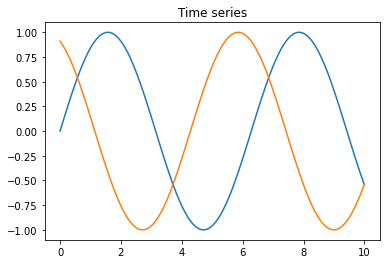

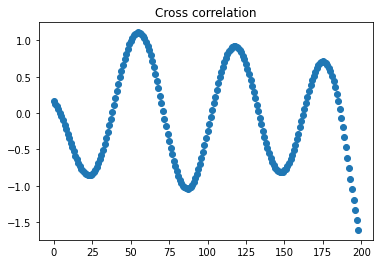

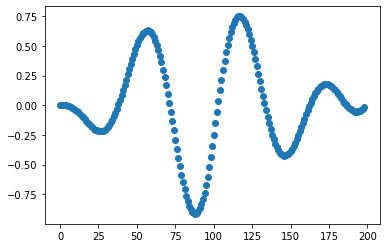

In [186]:
# Testing for corss correlation
t = np.linspace(0,10,100)

x = np.sin(t)
y = np.sin(t+ 2)

x_stand = (x -np.mean(x))/np.std(x)
y_stand = (y -np.mean(y))/np.std(y)

cross_corr = np.correlate(x_stand, y_stand, mode='full')
number_average = np.append(np.arange(1,101), (np.arange(1,100)[::-1]))
#normalized by overlap
cross_corr_normalize = cross_corr/number_average

plt.figure()
plt.plot(t, x)
plt.plot(t, y)
plt.title('Time series')
plt.show()


plt.figure()
plt.scatter(np.arange(cross_corr.size), cross_corr_normalize)
plt.title('Cross correlation')
plt.show()


plt.figure()
plt.scatter(np.arange(cross_corr.size), cross_corr/100)
plt.show()